In [1]:
%pip install matplotlib scipy tqdm
%matplotlib notebook

# imports
from tqdm import tqdm
import math
import numpy as np
import scipy.linalg
import cmath
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import time
matplotlib.use('nbagg')
from matplotlib.widgets import Slider, RadioButtons
import itertools

Note: you may need to restart the kernel to use updated packages.


In [2]:
########################################################################################################################
# Helpers
########################################################################################################################
# n_i as defined in the paper
# |1><1| acting on the i_th atom
def n_i(n_atoms, i):
    x = np.ones([1, 1])
    for j in range(i):
        x = np.kron(np.eye(2), x)
    x = np.kron(x, np.array([[0, 0], [0, 1]]))
    for j in range(i+1, n_atoms):
        x = np.kron(x, np.eye(2))
    return x

# Precompute part of the driver hamiltonian
# Final driver hamiltonian: H_driver = \omega(t)e^{i\phi(t)} * result + conj(\omega(t)e^{i\phi(t)} * result)
def raw_driver_hamiltonian(n_atoms):
    result = np.zeros([2**n_atoms, 2**n_atoms])
    for i in range(n_atoms):
        atom_hamiltonian = np.ones([1, 1])
        for j in range(i):
            atom_hamiltonian = np.kron(np.eye(2), atom_hamiltonian)
        atom_hamiltonian = np.kron(atom_hamiltonian, np.array([[0, 1], [0, 0]]))
        for j in range(i+1, n_atoms):
            atom_hamiltonian = np.kron(atom_hamiltonian, np.eye(2))
        result += atom_hamiltonian
    return result

# generate the interaction matrix from an array of atom coordinates
# V_0 is the interaction potential for two nearest (straight line) neighbors
def interactions(atoms, V_0):
    n_atoms = len(atoms)
    out = np.zeros([n_atoms, n_atoms])
    for i, p1 in enumerate(atoms):
        for j, p2 in list(enumerate(atoms))[i+1:]:
            eps = 1e-4
            norm = np.linalg.norm(p1 - p2)
            out[i][j] = V_0/(norm**6)
            out[j][i] = out[i][j]
    return out

# interactions: matrix V_ij in the paper
# Final cost hamiltonian: H_cost = \delta(t) * a + b
def raw_cost_hamiltonian(n_atoms, interactions):
    a = np.zeros([2**n_atoms, 2**n_atoms])
    b = np.zeros([2**n_atoms, 2**n_atoms])
    for i in range(n_atoms):
        a += n_i(n_atoms, i)
        for j in range(i):
            b += interactions[i][j] * np.matmul(n_i(n_atoms, i), n_i(n_atoms, j))
    return (-a, b)

# returns the expectation values of measuring every individual atom in the rydberg state
def measure(n_atoms, state):
    result = np.zeros([n_atoms])
    for i in range(n_atoms):
        result[i] = float(np.abs(np.conjugate(state) @ n_i(n_atoms, i) @ state))
    return result

# returns the expectation values of measuring every individual atom in the rydberg state
def measure_multiple(n_atoms, measure_indices, state):
    result = np.zeros([2**len(measure_indices)])
    for i, measured_state in enumerate(list(itertools.product([0, 1], repeat=len(measure_indices)))):
        op = np.ones([1, 1])
        for j in range(n_atoms):
            if j in measure_indices:
                idx_j = measure_indices.index(j)
                if measured_state[idx_j] == 0:
                    op = np.kron(op, np.array([[1, 0], [0, 0]]))
                else:
                    op = np.kron(op, np.array([[0, 0], [0, 1]]))
            else:
                op = np.kron(op, np.eye(2))
        result[i] = float(np.abs(np.conjugate(state) @ op @ state))
    return result

# returns the time-evolved state and the expectation values of isolated measurements per atom of the lowest-energy state
def evolve(n_atoms, H_driver_raw, H_cost_raw_a, H_cost_raw_b, delta, omega, phi, dt, state):
    cost_hamiltonian = delta * H_cost_raw_a + H_cost_raw_b
    full_hamiltonian = H_driver_raw * omega * (1 / 2.) * cmath.exp(1j * phi) + np.transpose(np.conjugate(H_driver_raw)) * omega * (1 / 2.) * cmath.exp(1j * (-phi)) + cost_hamiltonian
    vals, vecs = np.linalg.eig(full_hamiltonian)
    new_state = np.zeros_like(state, dtype='complex128')
    for i, val in enumerate(vals):
        new_state += np.exp(val * -1j * dt) * vecs[:, i] * (np.conjugate(np.transpose(vecs[:, i])) @ state)
    lowest_energy_expectations = measure(n_atoms, vecs[:, np.argmin(np.real(vals))])
    energy_gap = sorted(np.real(vals))[1] - sorted(np.real(vals))[0]
    return new_state, lowest_energy_expectations, energy_gap

In [3]:
########################################################################################################################
# Main implementation class
########################################################################################################################
class RydbergAtomArray:
    def __init__(self, V_0, atoms, state):
        self.V_0 = V_0
        self.atoms = atoms
        self.n_atoms = len(atoms)
        self.H_cost_raw_a, self.H_cost_raw_b = raw_cost_hamiltonian(self.n_atoms, interactions(self.atoms, V_0))
        self.H_driver_raw = raw_driver_hamiltonian(self.n_atoms)
        self.state = state
    def evolve(self, delta, omega, phi, dt):
        self.state, lowest_energy_expectations, energy_gap = evolve(self.n_atoms, self.H_driver_raw, self.H_cost_raw_a, self.H_cost_raw_b, delta, omega, phi, dt, self.state)
        self.state = self.state / np.linalg.norm(self.state)
        return lowest_energy_expectations, energy_gap
    def measure(self):
        return measure(self.n_atoms, self.state)

In [4]:
########################################################################################################################
# Simulation function
########################################################################################################################
def simulate(atoms, initial_state, deltas, omegas, phis, t, steps, show_tqdm=False):
    raa = RydbergAtomArray(100., np.array(atoms), initial_state)
    measurements = []
    states = []
    lowest_energy_expectations = []
    energy_gaps = []
    dt = t / steps
    #for i in tqdm(range(steps)):
    for i in (range(steps) if not show_tqdm else tqdm(range(steps))):
        lee, eg = raa.evolve(deltas[i], omegas[i], phis[i], dt)
        lowest_energy_expectations.append(lee)
        energy_gaps.append(eg)
        measurements.append((raa.measure()))
        states.append(raa.state)
    return np.array(measurements), np.array(energy_gaps), np.array(lowest_energy_expectations), np.array(states)

In [5]:
########################################################################################################################
# Visualization
########################################################################################################################
def plot_atom_array(atoms, vals, title, labels=True):
    grid_size = max(max(a) for a in atoms)
    fig, ax = plt.subplots()
    plt.title(title)
    fig.set_size_inches(5, 5)
    plt.ylim(-0.4, grid_size + 0.4)
    plt.xlim(-0.4, grid_size + 0.4)
    patches = []
    for i, (atom, val) in enumerate(zip(atoms, vals)):
        patches.append(ax.add_patch(plt.Circle(atom, 0.2, color=(1, 0, 0, val))))
        ax.add_patch(plt.Circle(atom, 0.2, color='k', linewidth=3, fill=False))
        ax.text(atom[0]-0.08, atom[1]-0.08, str(i+1), color="k", fontsize=24)
    plt.show()
    def update_vals(new_vals):
        for i in range(len(new_vals)):
            patches[i].set_facecolor((1, 0, 0, new_vals[i]))
    return update_vals
def plot_time_evolution(measurements):
    fig, ax = plt.subplots()
    plt.title("Time evolution")
    plt.xlabel("timestep")
    plt.ylabel("Isolated measurement expectation value")
    for i in range(len(atoms)):
        ax.plot(np.arange(len(measurements)), measurements[:, i], label="atom {}".format(i+1), linewidth=len(atoms)-i)
    plt.legend()
    plt.show()
def plot_lowest_energy_expectations(lowest_energy_expectations):
    fig, ax = plt.subplots()
    plt.title("Lowest energy eigenstate")
    plt.xlabel("timestep")
    plt.ylabel("Isolated measurement expectation value")
    for i in range(len(atoms)):
        plt.plot(np.arange(len(lowest_energy_expectations)), np.array(lowest_energy_expectations)[:, i], label="atom {}".format(i+1), linewidth=len(atoms)-i)
    plt.legend()
    plt.show()
def plot_parameters(deltas, omegas):
    fig, ax2 = plt.subplots()
    ax2.plot(np.arange(len(deltas)), deltas, label="delta")
    ax2.plot(np.arange(len(omegas)), omegas, label="omega")
    plt.xlabel("timestep")
    plt.title("Parameters")
    plt.legend()
    plt.show()
def plot_single_atom_and_parameters(deltas, omegas, expectation_values, lowest_energy_expectation_values, energy_gaps):
    fig, host = plt.subplots(figsize=(8,6)) # (width, height) in inches
    plt.subplots_adjust(left=0.1, bottom=0.15, right=0.7, top = 0.98)
    steps = np.arange(len(deltas))
    par1 = host.twinx()
    par2 = host.twinx()
    par3 = host.twinx()
    
    host.set_xlim(0, len(deltas) - 1)
    host.set_ylim(0, 1)
    par1.set_ylim(0, np.max(omegas) * 1.05)
    par2.set_ylim(np.min(deltas), np.max(deltas) * 1.05)
    par3.set_ylim(0, np.max(energy_gaps) * 1.05)

    host.set_xlabel("Timestep")
    host.set_ylabel("Isolated measurement expectation value")
    par1.set_ylabel("omega")
    par2.set_ylabel("delta")
    par3.set_ylabel("energy gap")

    color1 = "tab:blue"
    color2 = "tab:orange"
    color3 = "tab:green"
    color4 = "tab:red"
    color5 = "tab:purple"
    color6 = "tab:brown"

    p11, = host.plot(steps, expectation_values,    color=color1, label="Time evolution")
    p12, = host.plot(steps, lowest_energy_expectation_values,    color=color2, label="Lowest energy eigenstate")
    p13, = host.plot(steps, np.abs(expectation_values - lowest_energy_expectation_values),    color=color3, label="Time evolution error")
    p2, = par1.plot(steps, omegas,    color=color4, label="omega")
    p3, = par2.plot(steps, deltas, color=color5, label="delta")
    p4, = par3.plot(steps, energy_gaps, color=color6, label="energy gap")

    lns = [p11, p12, p13]
    host.legend(handles=lns, loc='upper center', bbox_to_anchor=(0.6, -0.1),
          fancybox=True, shadow=True, ncol=5)

    par2.spines['right'].set_position(('outward', 60))
    par3.spines['right'].set_position(('outward', 120))

    host.yaxis.label.set_color(p11.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    par3.yaxis.label.set_color(p4.get_color())
    
    plt.show()

In [6]:
########################################################################################################################
# Parameter generation helpers
########################################################################################################################
def generate_deltas_cubic(start, center, target, center_steepness, margin, n_samples):
    magic = np.array([
        [1, 0, 0, 0],
        [-5, 1, 4, -2],
        [8, -4, -4, 6],
        [-4, 4, 0, -4]
    ])
    center_slope = center_steepness * (target - start)
    #center_slope = (center_slope / (1/(1-2*margin)))
    poly = magic @ np.array([start, target, center, center_slope])
    def eval_at(x):
        if x <= margin:
            return start
        elif x >= 1 - margin:
            return target
        else:
            x = (x - margin) * (1/(1-2*margin))
            return poly[0] + poly[1] * x + poly[2] * x * x + poly[3] * x * x * x
    return np.array([eval_at(x) for x in np.linspace(0, 1, n_samples)])
def generate_omegas_trapezoid(omega, margin, n_samples):
    def eval_at(x):
        if x <= margin:
            return omega * (x / margin)
        elif x >= 1 - margin:
            return omega * ((1 - x) / margin)
        else:
            return omega
    return np.array([eval_at(x) for x in np.linspace(0, 1, n_samples)])


100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


<IPython.core.display.Javascript object>


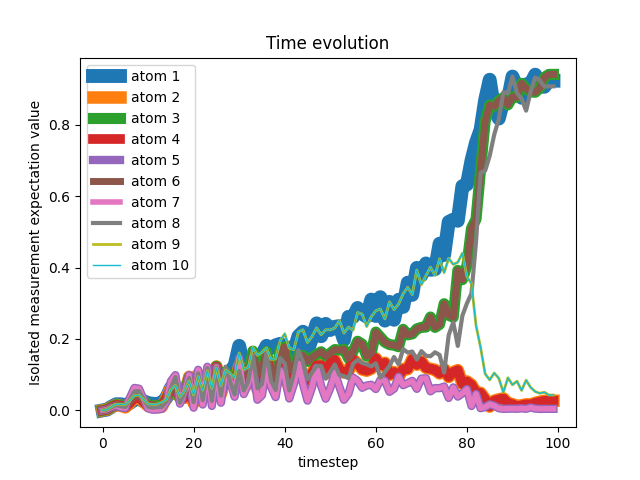

<IPython.core.display.Javascript object>


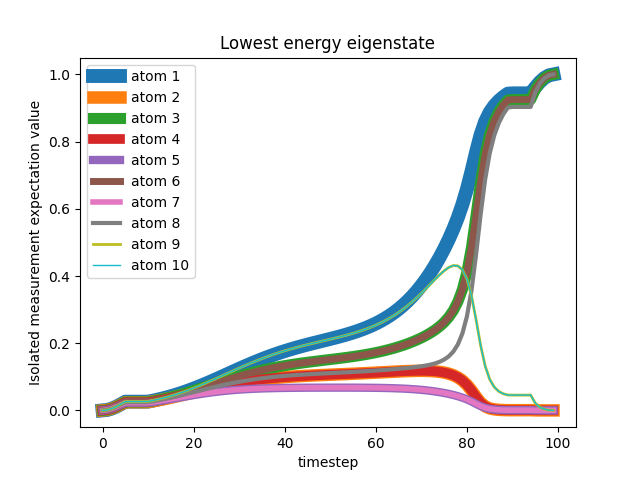

<IPython.core.display.Javascript object>


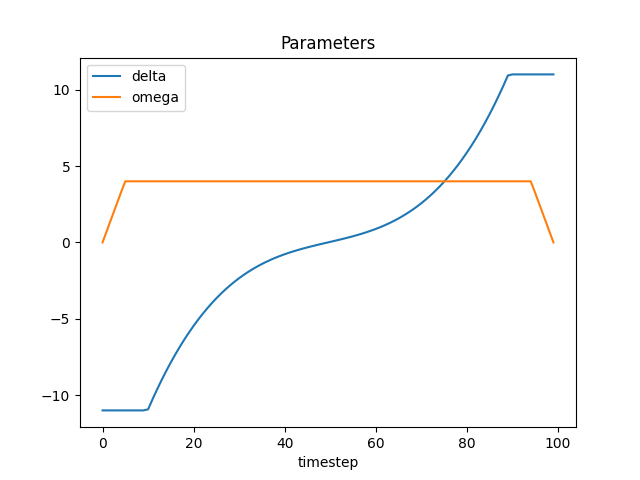

<IPython.core.display.Javascript object>


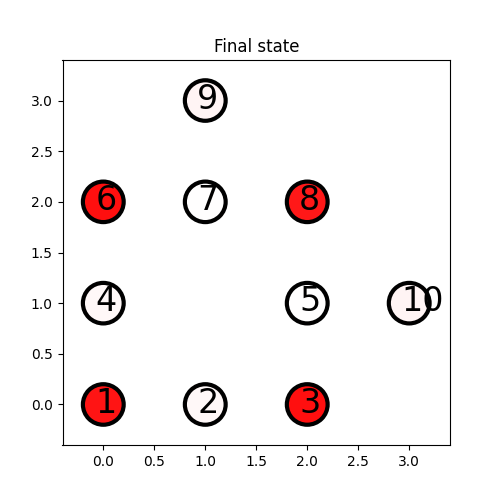

<function __main__.plot_atom_array.<locals>.update_vals(new_vals)>

In [23]:
########################################################################################################################
# Run single simulation
########################################################################################################################
# atom array
atoms = [
    [0, 0],
    [1, 0],
    [2, 0],
    [0, 1],
    [2, 1],
    [0, 2],
    [1, 2],
    [2, 2],
    [1, 3],
    [3, 1]
]
# initial state
initial_state = np.zeros(2**len(atoms))
initial_state[0] = 1
# time and resolution
t = 100.
steps = 100
# variational parameters
delta_start = -11.
delta_center = 0
delta_target = 11.
delta_center_steepness = 0.25
delta_margin = 0.1
omega = 4.
omega_margin = 0.05
deltas = generate_deltas_cubic(delta_start, delta_center, delta_target, delta_center_steepness, delta_margin, steps)
omegas = generate_omegas_trapezoid(omega, omega_margin, steps)
phis = np.array([0] * steps)
# simulation
measurements, energy_gaps, lowest_energy_expectations, _ = simulate(atoms, initial_state, deltas, omegas, phis, t, steps, show_tqdm=True)
plot_time_evolution(measurements)
plot_lowest_energy_expectations(lowest_energy_expectations)
plot_parameters(deltas, omegas)
plot_atom_array(atoms, measurements[-1], "Final state")
#plot_single_atom_and_parameters(deltas, omegas, measurements[:, 0], lowest_energy_expectations[:, 0], energy_gaps)

In [7]:
def plot_single_atom_and_parameters_interactive(atoms, update_vals):
    plt.ion()
    # initial state
    initial_state = np.zeros(2**len(atoms))
    initial_state[0] = 1
    # time and resolution
    t = 10.
    steps = 1000
    # variational parameters
    delta_start = -11.
    delta_center = 0.
    delta_target = 11.
    delta_center_steepness = 0.25
    delta_margin = 0.1
    omega = 4.
    omega_margin = 0.05
    deltas = generate_deltas_cubic(delta_start, delta_center, delta_target, delta_center_steepness, delta_margin, steps)
    omegas = generate_omegas_trapezoid(omega, omega_margin, steps)
    phis = np.array([0] * steps)
    measurements, energy_gaps, lowest_energy_expectations, states = simulate(atoms, initial_state, deltas, omegas, phis, t, steps)
    expectation_values, lowest_energy_expectation_values = measurements[:, 0], lowest_energy_expectations[:, 0]
    update_vals(measurements[-1])

    fig, host = plt.subplots(figsize=(9,8)) # (width, height) in inches
    plt.subplots_adjust(left=0.2, bottom=0.5, right=0.75, top = 0.98)
    steps = np.arange(len(deltas))
    par1 = host.twinx()
    par2 = host.twinx()
    par3 = host.twinx()
    
    host.set_xlim(0, len(deltas) - 1)
    host.set_ylim(0, 1)
    par1.set_ylim(0, omega * 1.1)
    par2.set_ylim(delta_start * 1.025, delta_target * 1.025)
    par3.set_ylim(0, np.max(energy_gaps) * 1.1)

    host.set_xlabel("Timestep")
    host.set_ylabel("Isolated measurement expectation value")
    par1.set_ylabel("omega")
    par2.set_ylabel("delta")
    par3.set_ylabel("energy gap")

    color1 = "tab:blue"
    color2 = "tab:orange"
    color3 = "tab:green"
    color4 = "tab:red"
    color5 = "tab:purple"
    color6 = "tab:brown"

    lines_te = []
    lines_lee = []
    lines_tee = []
    
    p11, = host.plot(steps, expectation_values,    color=color1, label="Time evolution")
    p12, = host.plot(steps, lowest_energy_expectation_values,    color=color2, label="Lowest energy eigenstate")
    p13, = host.plot(steps, np.abs(expectation_values - lowest_energy_expectation_values),    color=color3, label="Time evolution error")
    p2, = par1.plot(steps, omegas,    color=color4, label="omega")
    p3, = par2.plot(steps, deltas, color=color5, label="delta")
    p4, = par3.plot(steps, energy_gaps, color=color6, label="energy gap")

    lns = [p11, p12, p13]
    host.legend(handles=lns, loc='upper center', bbox_to_anchor=(0.6, -0.1),
          fancybox=True, shadow=True, ncol=5)

    par2.spines['right'].set_position(('outward', 60))
    par3.spines['right'].set_position(('outward', 120))

    host.yaxis.label.set_color(p11.get_color())
    par1.yaxis.label.set_color(p2.get_color())
    par2.yaxis.label.set_color(p3.get_color())
    par3.yaxis.label.set_color(p4.get_color())
    
    # Sliders
    # delta
    ax_delta_start = plt.axes([0.2, 0.35, 0.65, 0.03])
    delta_start_slider = Slider(
        ax=ax_delta_start,
        label='Delta Start',
        valmin=4*delta_start,
        valmax=0.,
        valinit=delta_start,
    )
    ax_delta_center = plt.axes([0.2, 0.3, 0.65, 0.03])
    delta_center_slider = Slider(
        ax=ax_delta_center,
        label='Delta Center',
        valmin=4*delta_start,
        valmax=4*delta_target,
        valinit=delta_center,
    )
    ax_delta_target = plt.axes([0.2, 0.25, 0.65, 0.03])
    delta_target_slider = Slider(
        ax=ax_delta_target,
        label='Delta Target',
        valmin=0,
        valmax=4*delta_target,
        valinit=delta_target,
    )
    ax_delta_center_steepness = plt.axes([0.2, 0.20, 0.65, 0.03])
    delta_center_steepness_slider = Slider(
        ax=ax_delta_center_steepness,
        label='Delta Steepness',
        valmin=0.,
        valmax=1.,
        valinit=delta_center_steepness,
    )
    # omega
    ax_omega = plt.axes([0.2, 0.15, 0.65, 0.03])
    omega_slider = Slider(
        ax=ax_omega,
        label='Omega amplitude',
        valmin=0,
        valmax=omega * 4,
        valinit=omega,
    )
    ax_omega_margin = plt.axes([0.2, 0.10, 0.65, 0.03])
    omega_margin_slider = Slider(
        ax=ax_omega_margin,
        label='Omega margin',
        valmin=0,
        valmax=0.5,
        valinit=omega_margin,
    )
    # time
    ax_t = plt.axes([0.2, 0.05, 0.65, 0.03])
    t_slider = Slider(
        ax=ax_t,
        label='Time',
        valmin=0,
        valmax=t * 10,
        valinit=t,
    )
    # check buttons
    rax = plt.axes([0.02, 0.7, 0.10, 0.03 * len(atoms)])
    labels = ["Atom {}".format(i+1) for i in range(len(atoms))]
    radio = RadioButtons(rax, labels)
    
    # called by radio buttons and sliders
    def update(val):
        # get selected atom
        chosen_idx = labels.index(radio.value_selected)
        # get slider values
        delta_start = delta_start_slider.val
        delta_center = delta_center_slider.val
        delta_target = delta_target_slider.val
        delta_center_steepness = delta_center_steepness_slider.val
        omega = omega_slider.val
        omega_margin = omega_margin_slider.val
        t = t_slider.val
        # simulate
        deltas = generate_deltas_cubic(delta_start, delta_center, delta_target, delta_center_steepness, delta_margin, len(steps))
        omegas = generate_omegas_trapezoid(omega, omega_margin, len(steps))
        measurements, energy_gaps, lowest_energy_expectations, final_state = simulate(atoms, initial_state, deltas, omegas, phis, t, len(steps))
        expectation_values, lowest_energy_expectation_values = measurements[:, chosen_idx], lowest_energy_expectations[:, chosen_idx]
        # update
        update_vals(measurements[-1])
        p3.set_ydata(deltas)
        p4.set_ydata(energy_gaps)
        p11.set_ydata(expectation_values)
        p12.set_ydata(lowest_energy_expectation_values)
        p13.set_ydata(np.abs(expectation_values - lowest_energy_expectation_values))
        p2.set_ydata(omegas)
        par1.set_ylim(0, omega * 1.1)
        par2.set_ylim(delta_start * 1.1, delta_target * 1.1)
        fig.canvas.draw()
        fig.canvas.flush_events()
        
    radio.on_clicked(update)
    delta_center_steepness_slider.on_changed(update)
    delta_center_slider.on_changed(update)
    delta_start_slider.on_changed(update)
    delta_target_slider.on_changed(update)
    omega_slider.on_changed(update)
    omega_margin_slider.on_changed(update)
    t_slider.on_changed(update)
    plt.show()

<IPython.core.display.Javascript object>


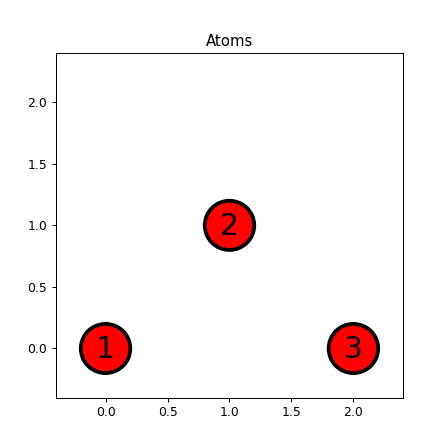

<IPython.core.display.Javascript object>


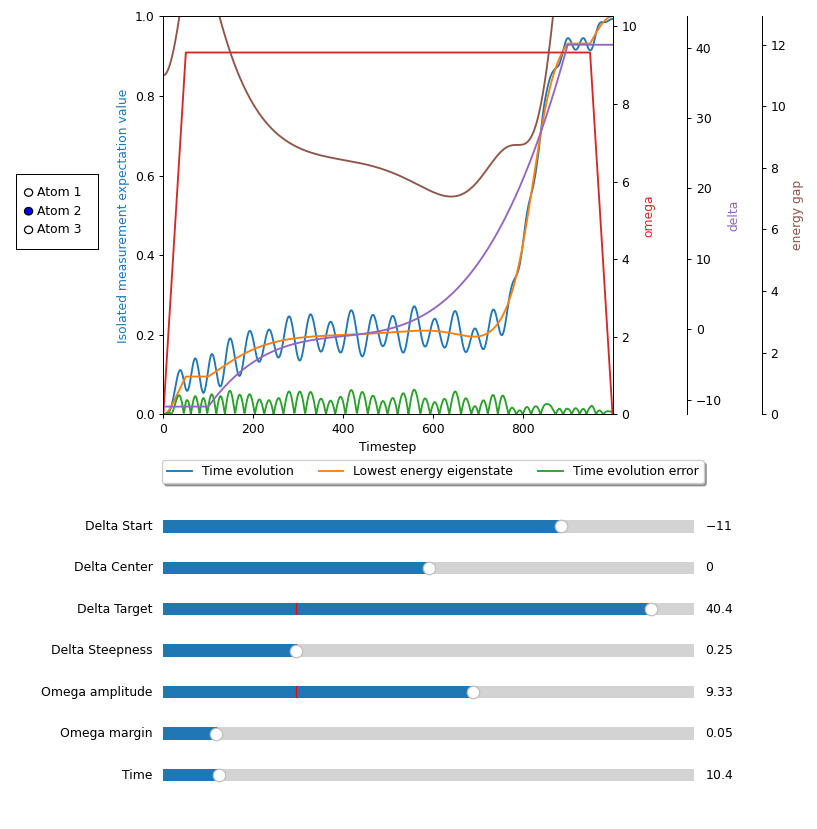

In [10]:
########################################################################################################################
# Run interactive simulation
########################################################################################################################
# atom array
atoms_3 = atoms = [
    [0, 0],
    [1, 1],
    [2, 0],
]
atoms_4 = atoms = [
    [0, 2],
    [0, 1],
    [0, 0],
    [1, 0],
]
atoms_5 = atoms = [
    [0, 2],
    [0, 1],
    [1, 0],
    [2, 1],
    [2, 2],
]
atoms_10 = [
    [0, 0],
    [1, 0],
    [2, 0],
    [0, 1],
    [2, 1],
    [0, 2],
    [1, 2],
    [2, 2],
]
atoms = atoms_3
# simulation
update_vals = plot_atom_array(atoms, [0] * len(atoms), "Atoms")
plot_single_atom_and_parameters_interactive(atoms, update_vals)

100%|██████████| 100/100 [00:00<00:00, 1202.50it/s]


<IPython.core.display.Javascript object>


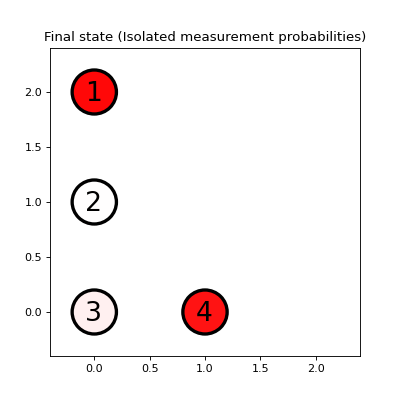

<IPython.core.display.Javascript object>


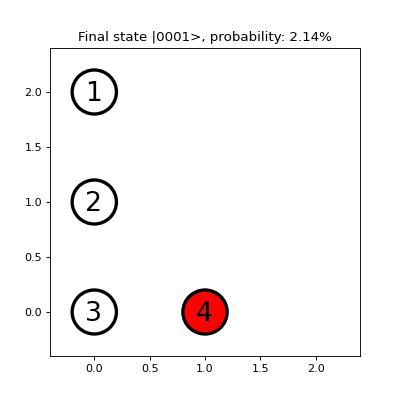

<IPython.core.display.Javascript object>


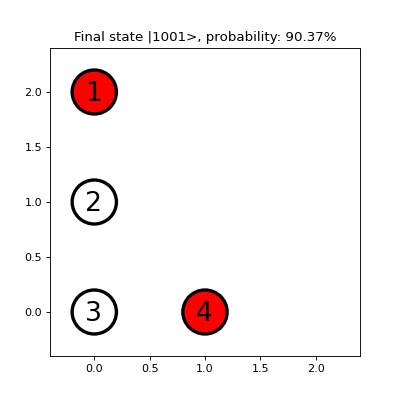

<IPython.core.display.Javascript object>


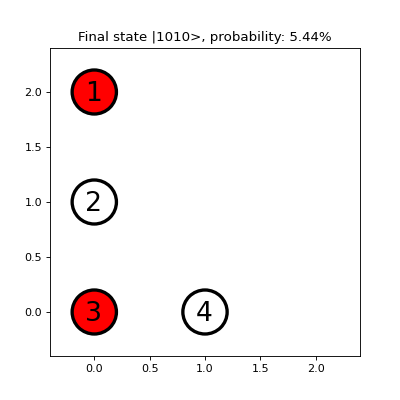

<IPython.core.display.Javascript object>


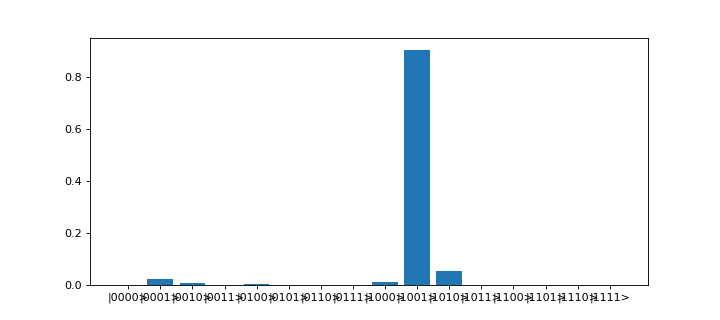

In [48]:
########################################################################################################################
# Run single simulation with full measurements
########################################################################################################################
# atom array
atoms_2 = [
    [0, 0],
    [1, 0],
]
atoms_4 = [
    [1, 2],
    [2, 1],
    [1, 0],
    [0, 1]
]
atoms_4_l = atoms = [
    [0, 2],
    [0, 1],
    [0, 0],
    [1, 0],
]
atoms_8 = [
    [1, 2],
    [2, 1],
    [1, 0],
    [0, 1],
    [5, 2],
    [6, 1],
    [5, 0],
    [4, 1]
]
atoms = atoms_4_l
# initial state
initial_state = np.zeros(2**len(atoms))
initial_state[0] = 1
# time and resolution
t = 100.
steps = 100
# variational parameters
delta_start = -11.
delta_center = 0
delta_target = 11.
delta_center_steepness = 0.25
delta_margin = 0.1
omega = 4.
omega_margin = 0.05
deltas = generate_deltas_cubic(delta_start, delta_center, delta_target, delta_center_steepness, delta_margin, steps)
omegas = generate_omegas_trapezoid(omega, omega_margin, steps)
phis = np.array([0] * steps)
# simulation
measurements, energy_gaps, lowest_energy_expectations, states = simulate(atoms, initial_state, deltas, omegas, phis, t, steps, show_tqdm=True)
#plot_time_evolution(measurements)
#plot_lowest_energy_expectations(lowest_energy_expectations)
#plot_parameters(deltas, omegas)
y = measure_multiple(len(atoms), list(range(len(atoms))), states[-1])
x = list(map(lambda x: "|" + "".join([str(a) for a in x]) + ">", itertools.product([0, 1], repeat=len(atoms))))
plot_atom_array(atoms, measurements[-1], "Final state (Isolated measurement probabilities)")
threshold_factor = 0.2
for i, (xi, yi) in enumerate(zip(x, y)):
    if yi > threshold_factor/len(x):
        active = np.array(list(itertools.product([0, 1], repeat=len(atoms)))[i])
        plot_atom_array(atoms, active, "Final state {}, probability: {:.2f}%".format(xi, yi * 100))
fig, ax = plt.subplots(figsize=(9,4))
ax.bar(x, y)
plt.show()